# Question 1


## code description : 
    
We create a function to sample from the distribution we just learned the
parameters of. epsilon is a tensor of small random normal values. One of 
the assumptions underlying a VAE like this is that our data arose from a 
random process and is normally distributed in the latent space.
'''

'''
We need one more thing and that's something that will calculate the unique 
loss function the VAE requires. Recall that the VAE is trained using a loss 
function with two components:

1 - 'Reconstruction loss' - This is the binary_crossentropy describing the errors 
between the decoded samples from the latent distribution and the original 
inputs.
2 - The Kullback-Liebler divergence between the latent distribution and the 
prior (this acts as a sort of regularization term).

We define a custom layer class that calculates the loss.
'''

'''
We can make predictions on the validation set using the encoder network. 
This has the effect of translating the images from the 784-dimensional 
input space into the 2-dimensional latent space. 
When we color-code those translated data points according to 
their known digit class, we can see how the digits cluster together.

In [6]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization, InputSpec
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 150
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255




In [7]:
# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)


# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 14, 14, 8)    32          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [8]:

# Define loss
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Train autoencoder
history = vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
# (François Chollet).
# Adapted to accomodate this VAE.
# =================

def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()



def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()
  


Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 19s 394us/step - loss: 269.8473 - val_loss: 278.8563
Epoch 2/150
48000/48000 [==============================] - 18s 374us/step - loss: 173.6076 - val_loss: 167.2305
Epoch 3/150
48000/48000 [==============================] - 21s 446us/step - loss: 165.6326 - val_loss: 165.2079
Epoch 4/150
48000/48000 [==============================] - 21s 430us/step - loss: 162.3691 - val_loss: 159.6401
Epoch 5/150
48000/48000 [==============================] - 19s 394us/step - loss: 160.8751 - val_loss: 157.9327
Epoch 6/150
48000/48000 [==============================] - 19s 406us/step - loss: 159.3814 - val_loss: 156.4502
Epoch 7/150
48000/48000 [==============================] - 18s 380us/step - loss: 158.8357 - val_loss: 156.0297
Epoch 8/150
48000/48000 [==============================] - 20s 409us/step - loss: 158.1496 - val_loss: 155.8783
Epoch 9/150
48000/48000 [=============================

48000/48000 [==============================] - 22s 451us/step - loss: 151.4495 - val_loss: 149.6796
Epoch 74/150
48000/48000 [==============================] - 20s 419us/step - loss: 151.3909 - val_loss: 150.7490
Epoch 75/150
48000/48000 [==============================] - 19s 404us/step - loss: 151.4505 - val_loss: 149.5520
Epoch 76/150
48000/48000 [==============================] - 19s 403us/step - loss: 150.9964 - val_loss: 149.6057
Epoch 77/150
48000/48000 [==============================] - 19s 402us/step - loss: 151.2914 - val_loss: 149.3238
Epoch 78/150
48000/48000 [==============================] - 20s 408us/step - loss: 151.2724 - val_loss: 151.2342
Epoch 79/150
48000/48000 [==============================] - 20s 420us/step - loss: 151.2807 - val_loss: 149.0434
Epoch 80/150
48000/48000 [==============================] - 19s 403us/step - loss: 151.3156 - val_loss: 149.0507
Epoch 81/150
48000/48000 [==============================] - 20s 408us/step - loss: 151.3606 - val_loss: 150.0

48000/48000 [==============================] - 18s 383us/step - loss: 150.3222 - val_loss: 148.1593
Epoch 146/150
48000/48000 [==============================] - 19s 402us/step - loss: 149.9101 - val_loss: 148.9634
Epoch 147/150
48000/48000 [==============================] - 20s 407us/step - loss: 150.1387 - val_loss: 149.8137
Epoch 148/150
48000/48000 [==============================] - 19s 392us/step - loss: 150.0304 - val_loss: 148.9826
Epoch 149/150
48000/48000 [==============================] - 19s 395us/step - loss: 150.0621 - val_loss: 148.3673
Epoch 150/150
48000/48000 [==============================] - 19s 402us/step - loss: 149.9478 - val_loss: 148.7388


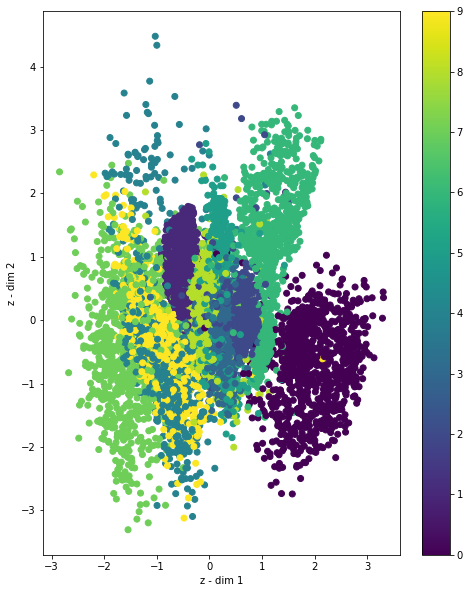

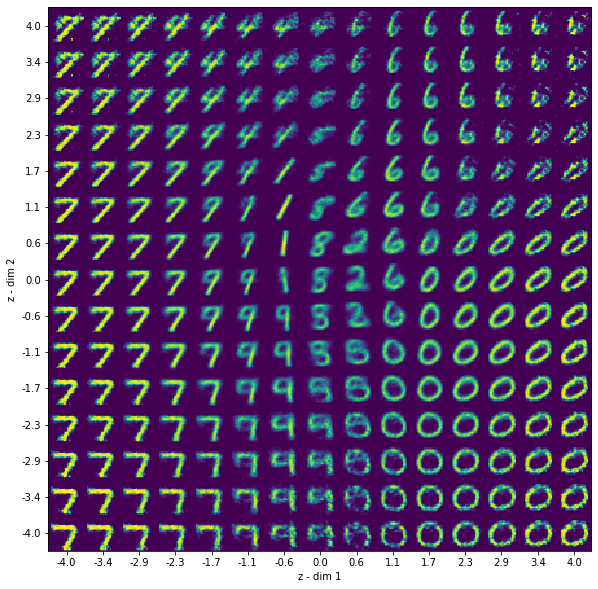

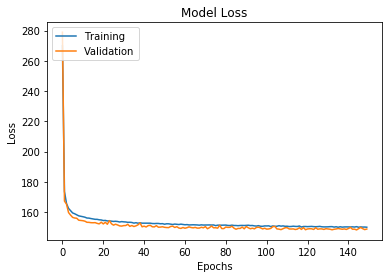

In [9]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()